# Nucleotide periodicity assessment
## Gene Transcription and Translation under Stress in *E. coli*

*Elliot Williams*<br>

## Overview of Logic

First, we read in all of the genes within the MazF-regulon, from `Maz_regulon2.txt`.

Next, we utilize Python code to produce a `one-gene-one-CDS` version of the MazF-regulon. 

Then, we do Information Theoretic analysis (for several runs) on this resulting dataset.

Finally, we do sequence walker analysis on the dataset, also.


In [56]:
%%capture
%load_ext rpy2.ipython
import warnings
from rpy2.rinterface import RRuntimeWarning
warnings.filterwarnings("ignore", category=RRuntimeWarning)
# This code just imports python libraries and initializes ray
import re
import pandas as pd
import csv
import random

## Importing MazF-regulon data

Here, we import the Maz_regulon from file.

In [7]:
f = open("./data/ecoli/Maz_regulon2.txt")
genes = [gene_symbol.strip() for gene_symbol in f]
print(genes[1:10])
print("There are {} genes in the MazF-regulon".format(
                        len(genes)))


['mscL', 'tatC', 'aroG', 'cycA', 'ptrB', 'sppA', 'yggG', 'srlB', 'pdxY']
There are 330 genes in the MazF-regulon


As you can see, the regulon imported successfully.

Next, we want to reuse (mostly)  the same Python program from the *H. sapiens* analysis to take the gene symbols we just imported from file, and get a 'one-gene-one-CDS' dataset associated with the regulon.

## Getting CDS Sequences for MazF-regulon genes

Here, we define a Python program that takes the gene symbols we just wrote to file, and grabs all of the CDS (ie mRNA sequences) associated with each respective gene sets from the *E. coli* CDS set.

In [131]:
def read_fasta_and_filter(fasta_file, gene_symbols, mode="up"):
    with open(fasta_file) as f:
        
        fasta_df = []
        header = ""
        sequence = ""
        hit_counter = 0
        gene_symbol = ""

        # This variable concatenates the dataset of sequences, obtaining
        # background nucleotide frequencies for the human genome
        total_sequence_aggregator = ""

        # Initializes dict containing counts for each gene_symbol
        gene_symbol_counter = {}
        for gene in gene_symbols:
            gene_symbol_counter[gene] = 0

        # Reads in all of lines in FASTA file
        while True:
            line = f.readline()
            # End condition
            if not line:
                # if we're exiting the loop, there should be an unwritten
                # header, sequence pair left to write
                if header and sequence and gene_symbol.strip() in gene_symbols:
                    # We write the unwritten pair, if it should be written
                    fasta_df.append([header, sequence, gene_symbol])
                    hit_counter += 1
                    gene_symbol_counter[gene_symbol] += 1

                if sequence[:3] is "ATG" and sequence[-3:] in ["TAA","TAG","TGA"]:
                    total_sequence_aggregator += sequence
                # Then we exit the loop
                break

            # Encountering a new FASTA header
            if line[0] == ">":
                # If appropriate, we write the header and sequence to our list
                if header and sequence and gene_symbol.strip() in gene_symbols:
                    fasta_df.append([header, sequence, gene_symbol])
                    hit_counter += 1
                    gene_symbol_counter[gene_symbol] += 1

                # Aggregates all valid genes to total_sequence_aggregator
                start = sequence[:3]
                end   = sequence[-3:]
                if start == "ATG" and (end in ["TAA","TAG","TGA"]):
                    total_sequence_aggregator += sequence

                # We read in the new header
                header = line[1:]
                # Parsing the gene_symbol using RegEx
                gene_symbol = re.search("(?<=gene_symbol:)[^\s]*", header).group(0)
                # Initialize new empty sequence
                sequence = ""
            # Adding to sequence
            else:
                sequence += re.sub("\s", "", line)

        avg_hits = sum(gene_symbol_counter.values())/len(gene_symbol_counter.values())
        avg_hits = round(avg_hits, 2)
        print("Number of hits is {}, average hits per gene is {}".format(round(hit_counter, 2), avg_hits))
        
        with open("./data/ecoli/runs/hits_{}.csv".format(mode), "w") as outfile:
           writer = csv.writer(outfile)
           writer.writerow(["num_hits"])
           writer.writerows(map(lambda x : [str(x)], gene_symbol_counter.values()))

        return [fasta_df, total_sequence_aggregator]

def read_gene_file(gene_file):
    with open(gene_file) as f:
        gene_names = []
        f.readline() # throws away header line
        while True:
            line = f.readline()
            if line:
                gene_names.append(line.strip())
            else:
                break

        return gene_names

def write_fasta_file(fasta_df, filename):
     with open("./data/hsapiens/{}".format(filename), "w") as outfile:
        writer = csv.writer(outfile)
        for fasta in fasta_df:
            writer.writerow(fasta)
     return
    

def calculate_nucleotide_freqs(total_seq):
    count_dict = {}
    for letter in total_seq:
        if letter not in count_dict:
            count_dict[letter] = 0
        count_dict[letter] += 1
    if "N" in count_dict:
        del count_dict["N"]

    total = count_dict["A"] + count_dict["T"] + count_dict["C"] + count_dict["G"]
    freq_dict = {k: v / float(total) for k, v in count_dict.items()}
    for nucleo in freq_dict:
        print("{} has frequency {}".format(nucleo, round(freq_dict[nucleo], 5)))
    return freq_dict

Now, we run this program on our MazF-regolon genes.

As a side effect, we also calculate the nucleotide frequencies associated with the Ensembl CDS dataset.

In [132]:
# For the upregulated set of D.E. Andreev genes
print(">>MazF-regulon genes")
fasta_file = "./data/ecoli/Escherichia_coli_str_k_12_substr_mg1655.ASM584v2.cds.all.fa"
[fasta_df, total_seq] = read_fasta_and_filter(fasta_file, genes, "ecoli")

# Calculating E. coli nucleotide frequencies
nucleo_freqs = calculate_nucleotide_freqs(total_seq)

# Converts fasta_df into a dataframe, to import to R
f_headers, cdss, f_genes = zip(*fasta_df)
cdss_f = [x[:35] for x in cdss]
fasta_pdf = pd.DataFrame(
{"fasta_header": f_headers,
 "cds": cdss_f,
 "gene_symbol": f_genes})

>>MazF-regulon genes
Number of hits is 303, average hits per gene is 0.92
A has frequency 0.24048
T has frequency 0.24025
G has frequency 0.27345
C has frequency 0.24582


We do, however, need a control to compare this set to.

So, we obtain a random subset of genes from the *E. coli* FASTA file of the same length as the MazF-regulon genes.

In [133]:
def read_all_valid_genes(fastafile):
    with open(fasta_file) as f:
        fasta_df = []
        header = ""
        sequence = ""

        while True:
            
            line = f.readline()
            
            # End of File
            if not line:
                if header and sequence:
                    if sequence[:3] == "ATG" and sequence[-3:] in ["TAA","TAG","TGA"]:
                        fasta_df.append([header, sequence, gene_symbol])
                break

            # Encountering a new FASTA header
            if line[0] == ">":
                # If appropriate, we write the header and sequence to our list
                if header and sequence:
                    if sequence[:3] == "ATG" and sequence[-3:] in ["TAA","TAG","TGA"]:
                        fasta_df.append([header, sequence, gene_symbol])

                # We read in the new header
                header = line[1:]
                # Parsing the gene_symbol using RegEx
                gene_symbol = re.search("(?<=gene_symbol:)[^\s]*", header).group(0)
                # Initialize new empty sequence
                sequence = ""
                
            # Adding to sequence
            else:
                sequence += re.sub("\s", "", line)
                
        return fasta_df
        
# Obtains all correct FASTA genes from *E. coli* CDS set
valid_genes = read_all_valid_genes("./data/ecoli/Escherichia_coli_str_k_12_substr_mg1655.ASM584v2.cds.all.fa")
print("There are {} valid genes within the FASTA file associated with E. coli".format(
                            len(valid_genes)))

# Converts this valid genes dataset to pandas DataFrame
c_headers, c_cdss, c_genes = zip(*valid_genes)
c_cdss_f = [x[:35] for x in c_cdss]
fasta_cdf = pd.DataFrame(
{"fasta_header": c_headers,
 "cds": c_cdss_f,
 "gene_symbol": c_genes})

There are 3747 valid genes within the FASTA file associated with E. coli


## Plotting the number of gene repetitions in E coli FASTA hits

We see above that the average number of FASTA hits for the *E. coli* genes is less than one. That, to me, suggests a CDS dataset in which there is only one coding sequence per gene.

Let's confirm this with a bar graph of the hits per gene.

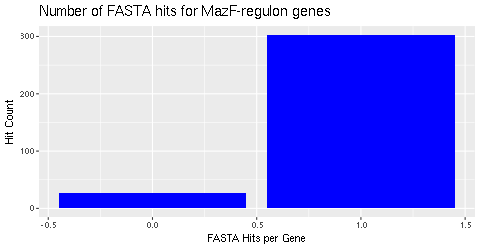

In [134]:
%%R -h 250
library(readr)
library(ggplot2)

df_fasta_hits_ecoli <- read_csv("./data/ecoli/runs/hits_ecoli.csv")

print(ggplot(df_fasta_hits_ecoli, aes(x=df_fasta_hits_ecoli)) + geom_bar(fill="blue") +
    labs(title="Number of FASTA hits for MazF-regulon genes",
         x="FASTA Hits per Gene", y="Hit Count"))

As you can see, for the *E. coli* FASTA set, each gene has either one or no hits. So, no random sampling is necessary. Let's see what both gene sets look like.

In [135]:
%%R -i fasta_cdf fasta_pdf

library(dplyr)
print("MazF-regulon genes")
glimpse(fasta_pdf)
print(min(nchar(fasta_pdf$cds)))
print("All valid E. coli genes")
glimpse(fasta_cdf)
print(min(nchar(fasta_pdf$cds)))


[1] "MazF-regulon genes"
Observations: 303
Variables: 3
$ cds          <chr> "ATGAAACGCATTAGCACCACCATTACCACCACCAT", "ATGCCAGATTTTTT...
$ fasta_header <chr> ">AAC73112 cds chromosome:ASM584v2:Chromosome:190:255:...
$ gene_symbol  <chr> "thrL", "yaaJ", "rpsT", "caiC", "ftsA", "nadC", "aroP"...
[1] 35
[1] "All valid E. coli genes"
Observations: 3,747
Variables: 3
$ cds          <chr> "ATGAAACGCATTAGCACCACCATTACCACCACCAT", "ATGCGAGTGTTGAA...
$ fasta_header <chr> "AAC73112 cds chromosome:ASM584v2:Chromosome:190:255:1...
$ gene_symbol  <chr> "thrL", "thrA", "thrB", "thrC", "yaaA", "yaaJ", "talB"...
[1] 35


## Information Theoretic Analysis

Now, we want to write or 

In [136]:
for nucleo in nucleo_freqs:
    print("{} has frequency {}".format(nucleo, round(nucleo_freqs[nucleo], 5)))

A has frequency 0.24048
T has frequency 0.24025
G has frequency 0.27345
C has frequency 0.24582


Here, we're outputting our three sets of filtered FASTA dataframes, 
for 5 samplings, to disk, to be used with the Information Theory IGS web tool.

(**Note:** We take a random sample of 5000 of the control genes, because the number of genes allowed to be input in the Information Theoretic Analysis on IGS server is less than the total number of genes in the D.E. Andreev control set)

In [137]:
%%R
fasta_pdf$fasta_header <- trimws(paste(">", fasta_pdf$fasta_header, sep=""))
fasta_cdf$fasta_header <- trimws(paste(">", fasta_cdf$fasta_header, sep=""))

mazf_lines = c(rbind(fasta_pdf$fasta_header, fasta_pdf$cds))
ctrl_lines = c(rbind(fasta_cdf$fasta_header, fasta_cdf$cds))

mazf_path <- "./data/ecoli/mazf_fasta.fa"
ctrl_path <- "./data/ecoli/ctrl_fasta.fa"

write_lines(mazf_lines, path=mazf_path)
write_lines(ctrl_lines, path=ctrl_path)

## Inputting into IGS Information Theory Tool

I did this manually. I could have done this via an automated process, and perhaps should develop a Selenium workflow to do this in future. The tool itself is found [here](http://igs.wesleyan.edu/), under 'Databases & Tools'.

## Reading in Results of Information Theory Analysis

Now, we're taking the csv representation of the results of said analysis, and producing two sets of data that we're trying to graph (associated with the MazF-regulon genes and the control genes, respectively).

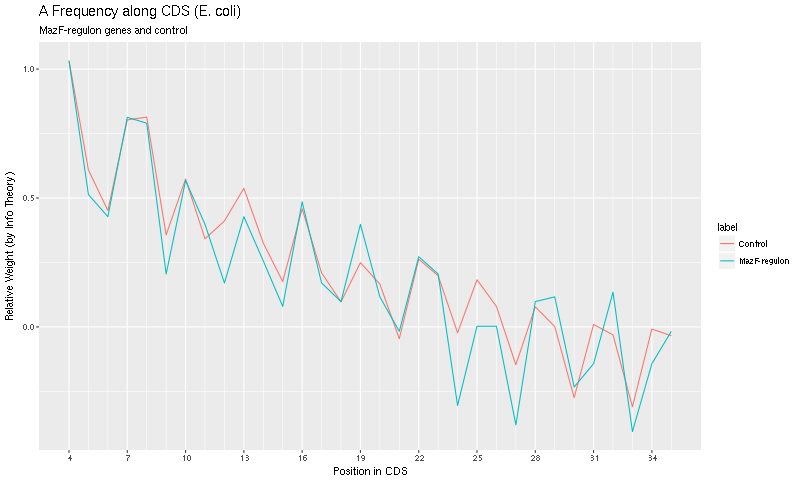

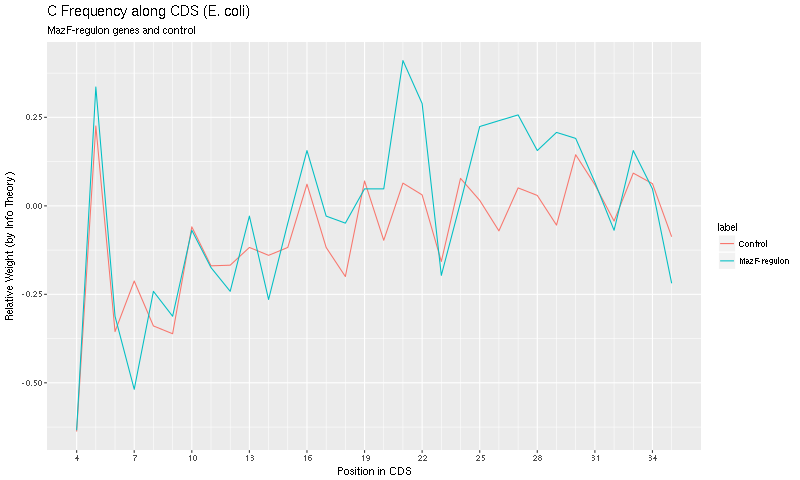

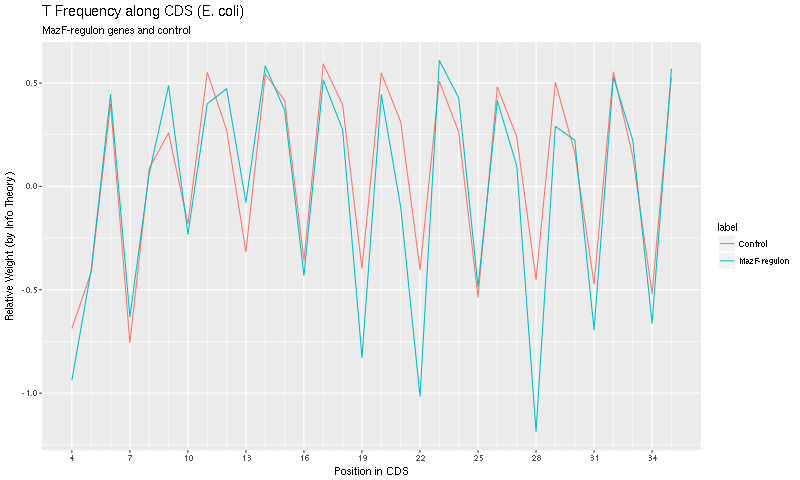

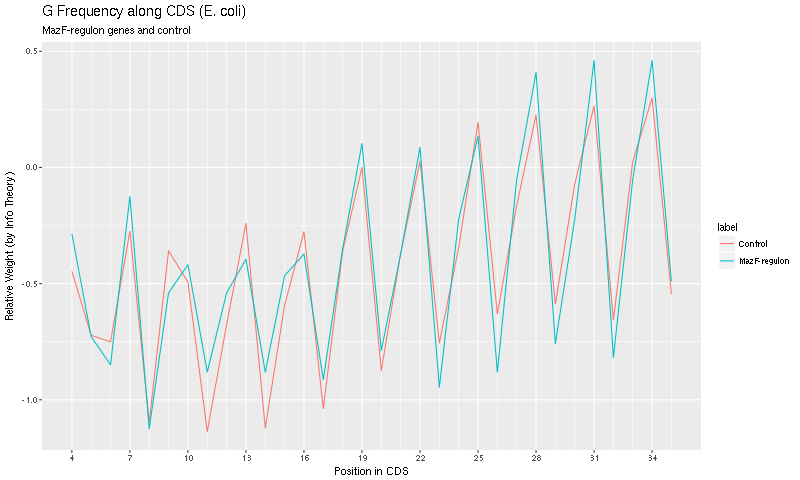

In [138]:
%%R -w 800
library(readr)
library(tidyr)
library(plyr)

info_mazf <- read_csv("./data/ecoli/infotheory_ecoli_mazf.csv") %>%
    select(pos, relWeightA, relWeightT, relWeightG, relWeightC) %>%
    gather(nucleotide, relativeWeight, -pos)
info_mazf$nucleotide <- mapvalues(info_mazf$nucleotide,
            from=c("relWeightA","relWeightC","relWeightT", "relWeightG"), 
            to=c("A","C","T","G"))

info_mazf <- info_mazf %>%
    mutate(label="MazF-regulon")
    
info_ctrl <- read_csv("./data/ecoli/infotheory_ecoli_ctrl.csv") %>%
    select(pos, relWeightA, relWeightT, relWeightG, relWeightC) %>%
    gather(nucleotide, relativeWeight, -pos)
info_ctrl$nucleotide <- mapvalues(info_ctrl$nucleotide,
            from=c("relWeightA","relWeightC","relWeightT", "relWeightG"), 
            to=c("A","C","T","G"))
info_ctrl <- info_ctrl %>%
    mutate(label="Control")
    
nucleotides <- c("A", "C", "T", "G")

info_combined <- rbind(info_mazf, info_ctrl)

for (nucleo in nucleotides){
    df <- filter(info_combined, nucleotide == nucleo, pos>3)
    print(ggplot(df, aes(x=pos, y=relativeWeight, color=label)) + geom_line() +
         xlim(4, 35) + scale_x_continuous(breaks=seq(4,35,3), minor_breaks=seq(4,35)) +
         labs(title=paste(nucleo, "Frequency along CDS (E. coli)"),
              subtitle="MazF-regulon genes and control", x="Position in CDS",
              y= "Relative Weight (by Info Theory)"))
}

Now, let's graph them all juxtaposed to each other, showcasing that the patterns
shown seem conserved across the board (to ensure the data is free of noise)

## Sequence Walker Analysis

Now that we've done other analysis of the *E. coli* gene set, we should perhaps do some sequence walker analysis too.

Recall the sequence walker code, shown below. 

(**Note:** This code was written by Prof. Weir, and modified by me to remove unnecessary elements for this notebook, as well as to port to Python 3)

In [130]:
'''
Computes the number of hydrogen bonds between
4-nt window of mRNA and 527 to 530 of rRNA 530 loop
(Note: In this case we're only doing the 2-mer model for C527, G528)
'''
def hbonds530(dna4):

    p = {}
    #p[0]={'A':0,'C':3,'G':0,'T':2}
    #p[1]={'A':0,'C':3,'G':0,'T':2}
    p[2]={'A':0,'C':0,'G':3,'T':0}
    p[3]={'A':0,'C':3,'G':0,'T':2}
    #p[4]={'A':0,'C':0,'G':3,'T':0}
    
    score = 0
    for i in range(2,4):
        score += p[i][dna4[i]]

    return score

# scans a DNA with 4-nt window according to hbonds530
def scan(dna):
    scores= []
    for i in range(len(dna)-3):
        scores += [hbonds530(dna[i:i+4])]
    return scores

# screens file with one DNA per line
def screendnas(dna_seq_list):
    
    scoreset = []
    for dna in dna_seq_list:
        scoreset += [scan(dna.strip()[:50])]
            
    n = len(scoreset)
    d = len(scoreset[0])
    
    averages = []
    for i in range(d):
        averages += [0]
    for i in range(d):
        for scores in scoreset:
            averages[i] += scores[i]
    results = []
    for a in range(d):
        results.append(averages[a]*1.0/n)
    return results

Let's ensure that all of the sequences have at least length 50, and plug the filtered sequence lists into the sequence walker code ...

In [143]:
# Filters out sequences with length less than 50
mazf_cds = list(filter(lambda x : len(x) >= 50, 
                                     cdss))
ctrl_cds = list(filter(lambda x : len(x) >= 50, 
                                       c_cdss))

# Runs sequence walker on all filtered sequence lists
mazf_walker = screendnas(mazf_cds)
ctrl_walker = screendnas(ctrl_cds)

walker_seqs = [mazf_walker, ctrl_walker]

... and let's graph them in R using `ggplot` ...

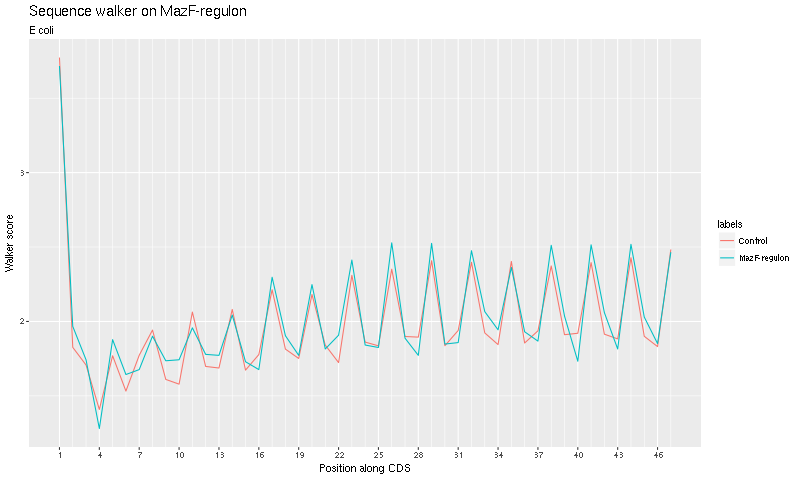

In [144]:
%%R -i walker_seqs -w 800

mazf_walker <- as.numeric(unlist(walker_seqs[[1]]))
ctrl_walker <- as.numeric(unlist(walker_seqs[[2]]))

total_walker <- c(mazf_walker, ctrl_walker)
position  <- seq(1, 47)
total_positions <- rep(position, 2)
labels <- c(rep("MazF-regulon", 47), rep("Control", 47))

df <- data.frame(total_positions, as.numeric(as.character(total_walker)), labels)
ggplot(df, aes(x=total_positions, y=total_walker, color=labels)) + geom_line() +
    labs(title="Sequence walker on MazF-regulon", subtitle="E coli",
         x="Position along CDS", y="Walker score") +
    scale_x_continuous(breaks=seq(1,47,3), minor_breaks=seq(1,47))

I don't think that there's a large enough data set to provide any conclusions from the *E. coli* analysis.